# Laboratory

**Author: @THEFFTKID**

Main notebook for experimentation.

In [3]:
cd ~/PedroPina/forecasting

C:\Users\DELL\PedroPina\forecasting


In [4]:
from mlflow import MlflowClient
import mlflow

In [5]:
# Flag experiment.
new_experiment = False
# Name
experiment_name = "A2C"
# Description.
experiment_description = (
    "Index - Stock forecasting project."
    "This experiment contains the models using AC2 policy."
)
# Tags
experiment_tags = {
    "project_name": "Continous update policy",
    "mlflow.note.content": experiment_description,
}
# TODO: Change each time.
run_name = "dynamic_threshold"


In [6]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

In [7]:
if new_experiment:
    # Creates the MLflow experiment.
    produce_experiment = client.create_experiment(
        name=experiment_name,
        tags=experiment_tags
    )

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import environments
import dataclasses
import numpy as np
import evaluation
import utils

from dynamic_threshold import define_threshold
from stable_baselines3 import A2C
from typing import List
from dataclasses import dataclass
from json import dumps

In [21]:
# Use the fluent API to set the tracking uri and the active experiment.
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current active experiment to the "index_forecast" experiment and returns the experiment metadata.
experiment = mlflow.set_experiment(experiment_name)

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
# run_name = "dynamic_threshold"

# Define an artifact path that the model will be saved to.
artifact_path = "a2c_index"

In [22]:
# Model parameters.
@dataclass
class ModelParameters:
    time_steps: int
    window_size: int
    data_path: str
    lower_threshold: float
    upper_threshold: float
    proportion: float
    features: List[str]

In [33]:
def train_experiment(parameters: ModelParameters):
    """
    Wrapper function for MLflow model versioning
    """
    # Read data.
    data = pd.read_csv(filepath_or_buffer=parameters.data_path)
    # Cast columns.
    data.columns = data.columns.str.lower()

    data['labels'], data['perc_relative_diff'] = evaluation.create_labels(
        x=data['close'],
        labels=[0, 1, 2],
        perc_bounds=[
            parameters.lower_threshold,
            parameters.upper_threshold
        ]
    )
    
    # Split dataset into train and test.
    df_train, df_test = evaluation.data_splitter(
        raw_data=data,
        proportion=parameters.proportion
    )

    # Create the environment.
    env = environments.Forecasting(
        df=df_train,
        window_size=parameters.window_size,
        series_features=parameters.features,
        lower_threshold=parameters.lower_threshold,
        upper_threshold=parameters.upper_threshold
    )

    # Train environment.
    model = A2C('MlpPolicy', env, verbose=1)
    # Learn.
    model.learn(total_timesteps=parameters.time_steps)

    # Initialize a new environment with test-set.
    env_test = environments.Forecasting(
        df=df_test,
        window_size=parameters.window_size,
        series_features=parameters.features,
        lower_threshold=parameters.lower_threshold,
        upper_threshold=parameters.upper_threshold
    )

    # Reset environment.
    observation, info = env_test.reset(
        upper_threshold=env.up_threshold,
        lower_threshold=env.low_threshold
    )

    while True: 
        observation = observation[np.newaxis, ...]
        action, states = model.predict(observation)
        observation, rewards, done, truncated, info = env_test.step(action)
        if done or truncated:
            print('info', info, '\n')
            break
    
    y_true = df_test['labels'].to_numpy()[parameters.window_size + 1:]
    y_pred = np.concatenate(env_test.actions_history)

    performance = evaluation.evaluation_metrics(
        y_true=y_true,
        y_pred=y_pred,
        target_names=['down', 'no', 'up']
    )

    print(dumps(performance, indent=4))

    # Logging params and metrics to MLflow.
    metrics = utils.flatten_dict(d=performance)

    # Log the parameters used for the model fit.
    mlflow.log_params(params=dataclasses.asdict(parameters))

    # Log the error metrics that were calculated during validation.
    mlflow.log_metrics(metrics=metrics)

    # TODO: Log an instance of the trained model for later use.

In [34]:
# Experiment parameters.
parameters = ModelParameters(
    time_steps=500,
    window_size=10,
    data_path='~/PedroPina/data/SPY_20122016.csv',
    lower_threshold=.5,
    upper_threshold=.5,
    proportion=0.8,
    features= [
        'open',
        'high',
        'low',
        'volume_roc',
        'n10_rolling_mean',
        'n10_weighted_rolling_mean',
        'momentum',
        'close',
        'nday_tendency_removal'
    ]
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 637      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.49    |
|    explained_variance | -0.0281  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.334    |
|    value_loss         | 0.15     |
------------------------------------
info {'total_reward': 118.88998599999991} 



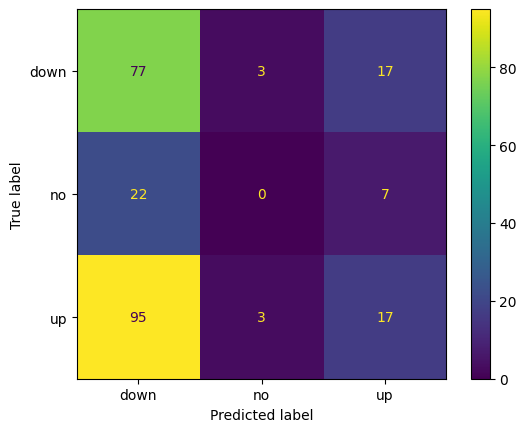

{
    "down": {
        "precision": 0.39690721649484534,
        "recall": 0.7938144329896907,
        "f1-score": 0.529209621993127,
        "support": 97.0
    },
    "no": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 29.0
    },
    "up": {
        "precision": 0.4146341463414634,
        "recall": 0.14782608695652175,
        "f1-score": 0.21794871794871798,
        "support": 115.0
    },
    "accuracy": 0.3900414937759336,
    "macro avg": {
        "precision": 0.27051378761210293,
        "recall": 0.31388017331540413,
        "f1-score": 0.249052779980615,
        "support": 241.0
    },
    "weighted avg": {
        "precision": 0.3576055055156361,
        "recall": 0.3900414937759336,
        "f1-score": 0.31700180870305344,
        "support": 241.0
    }
}


In [35]:
# Run for save the model.
with mlflow.start_run(run_name=run_name) as run:
    train_experiment(parameters=parameters)